<a href="https://colab.research.google.com/github/amirkasaei/Kidney-Renal-Cancer-Classification/blob/main/Kidney_Renal_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# imports
import glob
import cv2
import random
import copy
import time
import numpy as np

import torch
import torch.nn as nn
from tqdm.auto import tqdm, trange
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
# from torchvision import transforms
import torchvision


import matplotlib.pyplot as plt
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import pandas as pd
import shutil
import os

# Configs

In [5]:
torch.cuda.empty_cache()
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load Data

In [8]:
import gdown

url = 'https://drive.google.com/uc?id=1ilUsWNSde7aRd-oV3dKtCg3HDAuITqSy'


output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ilUsWNSde7aRd-oV3dKtCg3HDAuITqSy
From (redirected): https://drive.google.com/uc?id=1ilUsWNSde7aRd-oV3dKtCg3HDAuITqSy&confirm=t&uuid=5459d54e-37a9-43bf-ba08-fad1e608b836
To: /content/dataset.zip
100%|██████████| 199M/199M [00:03<00:00, 59.9MB/s]


'dataset.zip'

In [9]:
! unzip -q dataset.zip

In [10]:
classes = {
    'AML': 0,
    'Chromophobe RCC': 1,
    'Clear Cell RCC': 2,
    'High Grade Urothelial Papillary Carcinoma': 3,
    'Hydatid Cyst': 4,
    'Low Grade Papillary Urothelial Carcinoma': 5,
    'Multilucolar Cystic Renal Neoplasm of Low Malignant': 6,
    'Papillary RCC type 1': 7,
    'Papillary RCC type 2': 8,
    'Sarcomatoid RCC': 9,
    'SCC': 10,
    'Simple Cyst': 11,
    'Complicated cyst':12,
    'Oncocytoma':13,
    'Others':14
}

In [11]:
def create_dataset(path):
  dataset = {
      'image_path': [],
      'class_name': [],
      'label': []
  }
  for image_path in glob.iglob(path + '/**/*.png'):
    class_name = image_path.split('/')[-2]
    dataset['image_path'].append(image_path)
    dataset['class_name'].append(class_name)
    dataset['label'].append(classes[class_name])

  return dataset

In [12]:
# p = '/content/Rencal Cancer merged/With Contrastive agent'
p = '/content/With Contrastive agent'
data = create_dataset(p)

In [37]:
dataframe = pd.DataFrame(data)
dataframe.head()

,image_path,class_name,label
0,/content/With Contrastive agent/Low Grade Papi...,Low Grade Papillary Urothelial Carcinoma,5
1,/content/With Contrastive agent/Low Grade Papi...,Low Grade Papillary Urothelial Carcinoma,5
2,/content/With Contrastive agent/Low Grade Papi...,Low Grade Papillary Urothelial Carcinoma,5
3,/content/With Contrastive agent/SCC/AKHSHIJAN^...,SCC,10
4,/content/With Contrastive agent/SCC/AKHSHIJAN^...,SCC,10


In [38]:
class_counts = dataframe['class_name'].value_counts(sort=True)
print(class_counts)

Clear Cell RCC                               191
Simple Cyst                                  157
Chromophobe RCC                              105
AML                                           73
Sarcomatoid RCC                               42
Others                                        20
Oncocytoma                                    18
Complicated cyst                              15
SCC                                            9
Hydatid Cyst                                   7
High Grade Urothelial Papillary Carcinoma      7
Papillary RCC type 2                           6
Low Grade Papillary Urothelial Carcinoma       3
Papillary RCC type 1                           3
Name: class_name, dtype: int64


In [40]:
classes = class_counts[class_counts >= 20].index
classes

Index(['Clear Cell RCC', 'Simple Cyst', 'Chromophobe RCC', 'AML',
       'Sarcomatoid RCC', 'Others'],
      dtype='object')

In [42]:
dataframe_filtered = dataframe.copy(deep=True)
dataframe_filtered.loc[~dataframe_filtered.class_name.isin(classes), 'class_name'] = 'Others'
dataframe_filtered['class_name'].value_counts(sort=True)

Clear Cell RCC     191
Simple Cyst        157
Chromophobe RCC    105
Others              88
AML                 73
Sarcomatoid RCC     42
Name: class_name, dtype: int64

In [ ]:
# dataframe_filtered = dataframe[dataframe.class_name.isin(classes)]
# dataframe_filtered.head()

In [44]:
for i in range(len(classes)):
  class_indicies = dataframe_filtered['class_name'] == classes[i]
  dataframe_filtered.loc[class_indicies, 'label'] = i

In [45]:
dataframe_filtered.head()

,image_path,class_name,label
0,/content/With Contrastive agent/Low Grade Papi...,Others,5
1,/content/With Contrastive agent/Low Grade Papi...,Others,5
2,/content/With Contrastive agent/Low Grade Papi...,Others,5
3,/content/With Contrastive agent/SCC/AKHSHIJAN^...,Others,5
4,/content/With Contrastive agent/SCC/AKHSHIJAN^...,Others,5


# Dataset and Dataloader

In [46]:
class RencalCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.dataframe = df
        self.trasnform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        image_path, label = self.dataframe[['image_path', 'label']].iloc[index]

        image = cv2.imread(image_path)
        # image = Image.open(image_path)
        image = self.trasnform(image)

        return image, label

In [47]:
train_data, test_data = train_test_split(dataframe_filtered, test_size=0.2, random_state=42)

In [48]:
train_data.head()

,image_path,class_name,label
61,/content/With Contrastive agent/Clear Cell RCC...,Clear Cell RCC,0
596,/content/With Contrastive agent/AML/TAHERI^PAR...,AML,3
623,/content/With Contrastive agent/AML/JABARI^HOS...,AML,3
29,/content/With Contrastive agent/Others/TASBIHI...,Others,5
377,/content/With Contrastive agent/Sarcomatoid RC...,Sarcomatoid RCC,4


In [49]:
train_data['class_name'].value_counts()

Clear Cell RCC     146
Simple Cyst        131
Chromophobe RCC     82
Others              71
AML                 54
Sarcomatoid RCC     40
Name: class_name, dtype: int64

In [50]:
datasets = {}
phases = ['train', 'valid', 'test']

In [51]:
PILimage = T.Compose([
    T.ToPILImage()
])

transformers = [
    T.functional.vflip,
    T.functional.hflip,
    T.RandomRotation((90, 90)),
    T.RandomRotation((180, 180)),
    T.RandomRotation((270, 270))
]


randomAug = T.RandomApply([T.RandomChoice(transformers)], p=0.5)

train_transformations = T.Compose([
    T.ToPILImage(),
    T.CenterCrop((820, 900)),
    T.Resize((224 , 224)),
    T.RandomApply([T.RandomChoice(transformers)], p=0.5),
    T.ToTensor(),
])

test_transformations = T.Compose([
    T.ToPILImage(),
    T.CenterCrop((820, 900)),
    T.Resize((224 , 224)),
    T.ToTensor(),
])

In [52]:
datasets['train'] = RencalCancerDataset(train_data, train_transformations)
datasets['test'] = RencalCancerDataset(test_data, test_transformations)

In [53]:
datasets['train'][10][0].shape

torch.Size([3, 224, 224])

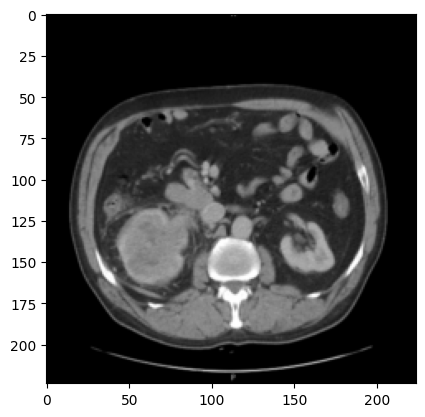

In [54]:
plt.imshow(PILimage(datasets['test'][10][0]))

In [55]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], shuffle=True, batch_size=32)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], shuffle=False, batch_size=32)

# Train

In [73]:
def one_epoch(model, loader, criterion, optimizer, scheduler, device, phase):

  if phase == 'train':
    model.train() # Set model to training mode
  else:
    model.eval()

  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  running_f1_score = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

    # statistics
    running_loss += loss.item()
    running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())
    running_precision += sklearn.metrics.precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_recall += sklearn.metrics.recall_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_f1_score += sklearn.metrics.f1_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)

    if phase == 'train' and scheduler:
        scheduler.step()

  loss = running_loss / len(loader)
  accuracy = running_accuracy / len(loader)
  precision = running_precision / len(loader)
  recall = running_recall / len(loader)
  f1_score = running_f1_score / len(loader)

  return loss, accuracy, precision, recall, f1_score

In [74]:
def train(model, loaders, criterion, optimizer, num_epochs, device, scheduler=None):

  best_val_loss = float('inf')
  best_val_acc = 0
  # best_model = None

  accuracy_dic, loss_dic = {}, {}
  loss_dic['train'], loss_dic['validation'] = [], []
  accuracy_dic['train'], accuracy_dic['validation'] = [], []

  for epoch in range(num_epochs):
      train_loss, train_acc, train_precision, train_recall, train_f1 = one_epoch(model, loaders['train'], criterion, optimizer, scheduler, device, phase='train' )
      # val_loss, val_acc, val_precision, val_recall, val_f1 = one_epoch(model, loaders['validation'], criterion, optimizer, scheduler, device, phase='validation')

      loss_dic['train'].append(train_loss)
      # loss_dic['validation'].append(val_loss)
      accuracy_dic['train'].append(train_acc)
      # accuracy_dic['validation'].append(val_acc)

      # if val_loss < best_val_loss:
      #   best_val_acc = val_acc
      #   best_val_loss = val_loss
      #   # best_model = model.state_dict()
      #   torch.save(model.state_dict(), model_path)


      print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Train Accuracy: {train_acc:.4f} - '
            f'Train Precision {train_precision:.4f} - '
            f'Train Recall {train_recall:.4f} - '
            f'Train F1-score {train_f1:.4f} ')
            # f'Validation Loss: {val_loss:.4f} - '
            # f'Validation Accuracy {val_acc:.4f} - '
            # f'Validation Precision {val_precision:.4f} - '
            # f'Validation Recall {val_recall:.4f} - '
            # f'Validation F1-score {val_f1:.4f} ')

  return loss_dic, accuracy_dic

In [75]:
def show_plots(num_epochs, data, metric):
  e = np.arange(num_epochs)
  plt.plot(e, data['train'], label='train '+metric)
  # plt.plot(e, data['valid'], label='validation '+metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()

In [ ]:
# model = torchvision.models.alexnet(pretrained=True)
# input_features = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(in_features=input_features, out_features=len(classes), bias=True)

model = torchvision.models.resnet18(pretrained=True)
input_features = model.fc.in_features
model.fc = nn.Linear(in_features=input_features, out_features=len(classes), bias=True)

model.to(device)

In [77]:
classes

Index(['Clear Cell RCC', 'Simple Cyst', 'Chromophobe RCC', 'AML',
       'Sarcomatoid RCC', 'Others'],
      dtype='object')

In [78]:
class_weights=compute_class_weight('balanced', classes=classes, y=train_data['class_name'])
class_weights = torch.FloatTensor(class_weights).to(device)
class_weights

tensor([0.5982, 0.6667, 1.0650, 1.6173, 2.1833, 1.2300], device='cuda:0')

In [79]:
model_path = '/content'

In [80]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 20

In [81]:
loss_dic, accuracy_dic = train(model, dataloaders, criterion, optimizer, num_epochs, device, scheduler=None)

Epoch [1/20] - Train Loss: 1.2406 - Train Accuracy: 0.5417 - Train Precision 0.6421 - Train Recall 0.5417 - Train F1-score 0.5483 
Epoch [2/20] - Train Loss: 0.4873 - Train Accuracy: 0.8707 - Train Precision 0.9171 - Train Recall 0.8707 - Train F1-score 0.8806 
Epoch [3/20] - Train Loss: 0.2757 - Train Accuracy: 0.9216 - Train Precision 0.9485 - Train Recall 0.9216 - Train F1-score 0.9271 
Epoch [4/20] - Train Loss: 0.1437 - Train Accuracy: 0.9651 - Train Precision 0.9743 - Train Recall 0.9651 - Train F1-score 0.9666 
Epoch [5/20] - Train Loss: 0.0988 - Train Accuracy: 0.9786 - Train Precision 0.9871 - Train Recall 0.9786 - Train F1-score 0.9804 
Epoch [6/20] - Train Loss: 0.0840 - Train Accuracy: 0.9822 - Train Precision 0.9891 - Train Recall 0.9822 - Train F1-score 0.9844 
Epoch [7/20] - Train Loss: 0.0745 - Train Accuracy: 0.9841 - Train Precision 0.9894 - Train Recall 0.9841 - Train F1-score 0.9848 
Epoch [8/20] - Train Loss: 0.0410 - Train Accuracy: 0.9963 - Train Precision 0.9972

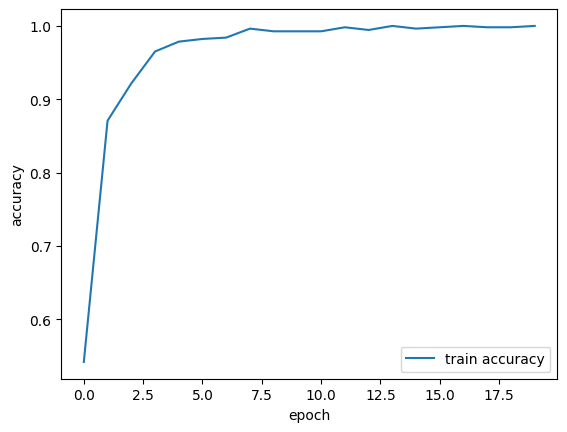

In [84]:
show_plots(num_epochs, accuracy_dic, 'accuracy')

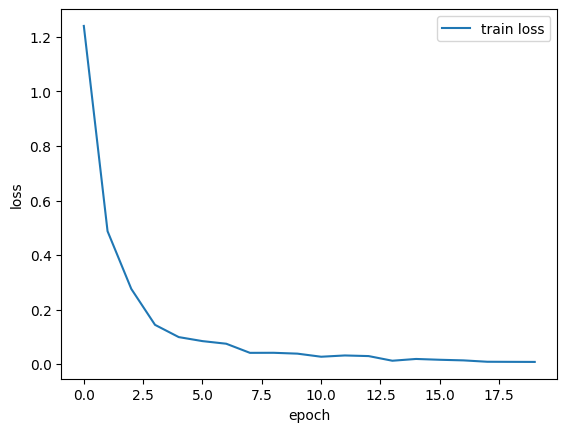

In [85]:
show_plots(num_epochs, loss_dic, 'loss')

# Evaluate

In [86]:
def evaluate(model, loaders, criterion, optimizer, device, phase, scheduler=None):

  loss, accuracy, precision, recall, f1_score = one_epoch(model, loaders[phase], criterion, optimizer, scheduler, device, 'test')

  print(f'{phase} Loss: {loss:.4f} - '
        f'{phase} Acuracy {accuracy:.2f} - '
        f'{phase} Precision: {precision:.2f} - '
        f'{phase} Recall {recall:.2f} - '
        f'{phase} F1: {f1_score:.2f}')


In [87]:
def plot_confusionmatrix(y_pred, y_true, classes):
  print('Confusion matrix')
  cf = sklearn.metrics.confusion_matrix(y_pred, y_true)
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

In [88]:
def report(model, loader, device, classes):

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  y_pred = []
  y_true = []

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      y_pred.extend(preds.cpu())
      y_true.extend(labels)

  plot_confusionmatrix(y_pred, y_true, classes)

In [89]:
# model.load_state_dict(torch.load(model_path))

In [90]:
evaluate(model, dataloaders, criterion, optimizer, device, 'train')

train Loss: 0.0018 - train Acuracy 1.00 - train Precision: 1.00 - train Recall 1.00 - train F1: 1.00


Confusion matrix


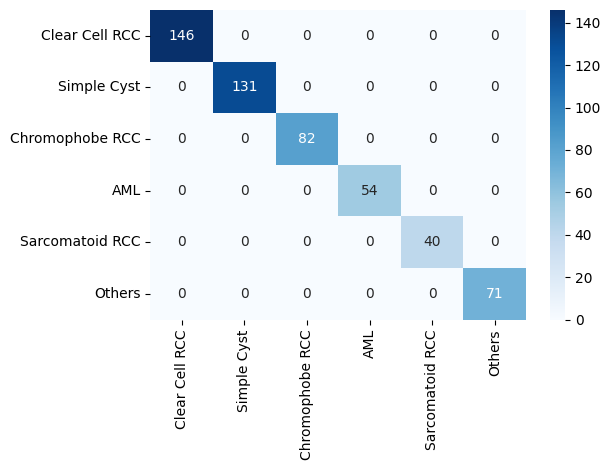

In [91]:
report(model, dataloaders['train'], device, classes)

In [92]:
evaluate(model, dataloaders, criterion, optimizer, device, 'test')

test Loss: 0.0060 - test Acuracy 1.00 - test Precision: 1.00 - test Recall 1.00 - test F1: 1.00


Confusion matrix


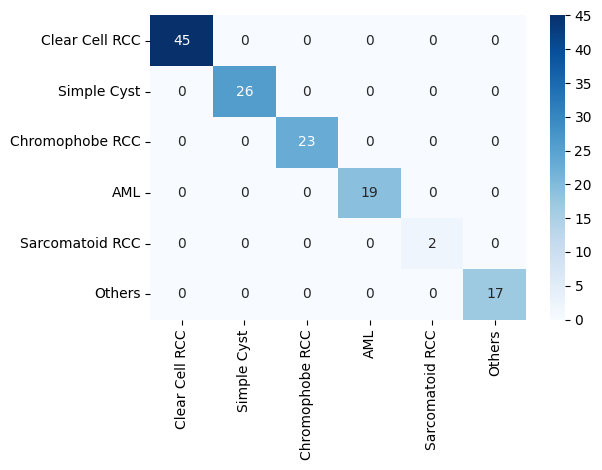

In [93]:
report(model, dataloaders['test'], device, classes)

# Interpretability (GradCam)

In [94]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import to_pil_image


def plot_GradCam(model, image):
    target_layers = [model.layer4[-1]]
    input_tensor = torch.unsqueeze(image, dim=0)
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(1)] # one class

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    img = np.array(to_pil_image(image))/255

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    return grayscale_cam, visualization


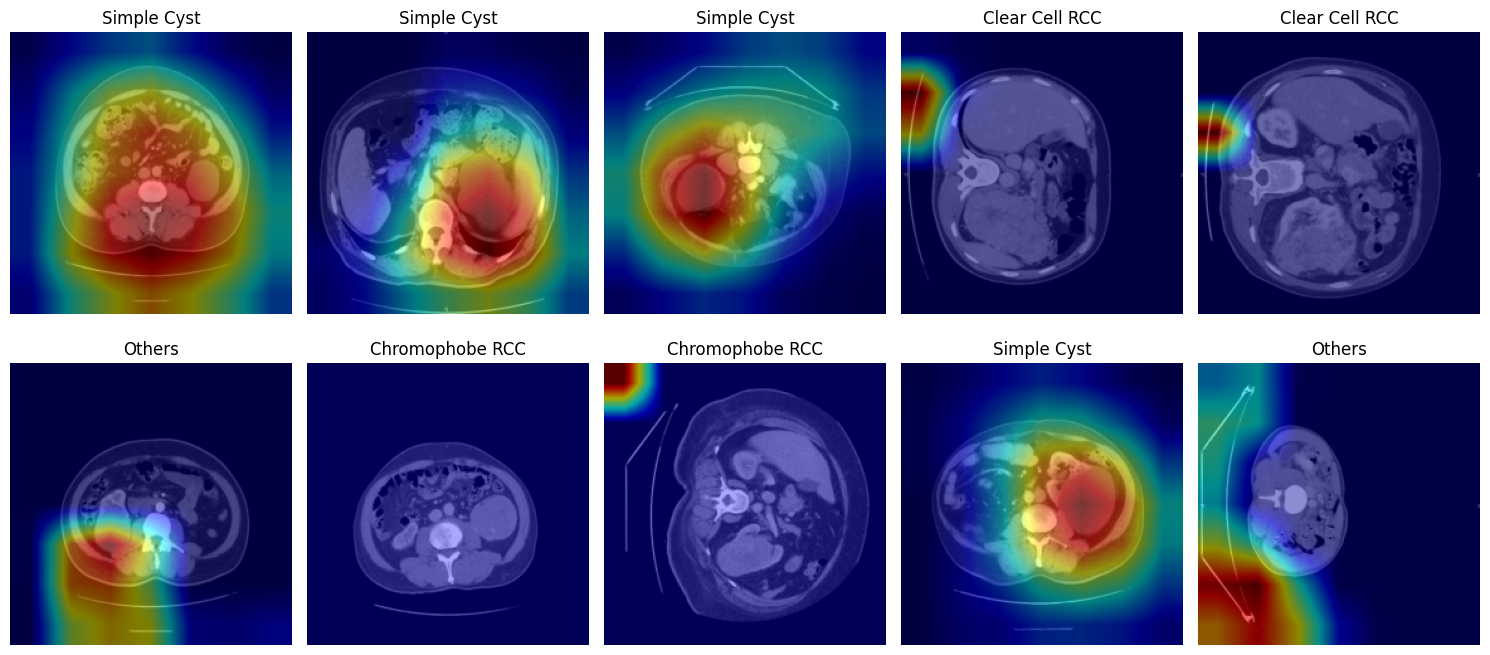

In [95]:
k=10
indicies = np.random.choice(len(datasets['train']), k)
np.random.shuffle(indicies)

fig,axs = plt.subplots(2,5, figsize=(15,7))
idx=0

for i, ax in enumerate(axs.flatten()):
  image, label = datasets['train'][indicies[idx]]
  grayscale_cam, vis = plot_GradCam(model, image)
  ax.imshow(vis)
  ax.axis("off")
  ax.title.set_text(classes[label])
  idx += 1

plt.tight_layout()
plt.show()